In [11]:
!git clone https://github.com/deepseek-ai/Janus.git

Cloning into 'Janus'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 121 (delta 57), reused 41 (delta 41), pack-reused 38 (from 1)
Receiving objects: 100% (121/121), 7.18 MiB | 43.01 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [12]:

%cd Janus
!pip install -e .
!pip install flash-attn

/kaggle/working/Janus/Janus
Obtaining file:///kaggle/working/Janus/Janus
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for janus (pyproject.toml) ... done
  Created wheel for janus: filename=janus-1.0.0-0.editable-py3-none-any.whl size=15921 sha256=f8fc33a3c7db03952240b24c542f39fc88d0f37c70c03f80417df64dc0ecfe90
  Stored in directory: /tmp/pip-ephem-wheel-cache-oj2ph69u/wheels/78/f7/50/104a4e0a3a0f655bccda4219c02c9fba1df84b34814edf775c
Successfully built janus
  Attempting uninstall: janus
    Found existing installation: janus 1.0.0
    Uninstalling janus-1.0.0:
      Successfully uninstalled janus-1.0.0


In [13]:
import torch
from transformers import AutoConfig, AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images
from PIL import Image

import numpy as np
import os
import time

In [14]:
model_path = '/kaggle/input/janus-pro/pytorch/1b/1'
config = AutoConfig.from_pretrained(model_path)
language_config = config.language_config
language_config._attn_implementation = 'eager'
vl_gpt = AutoModelForCausalLM.from_pretrained(model_path,
                                             language_config=language_config,
                                             trust_remote_code=True)

cuda_device = 'cuda' if torch.cuda.is_available() else 'cpu'
if cuda_device == 'cuda':
    vl_gpt = vl_gpt.to(torch.bfloat16).cuda()
else:
    vl_gpt = vl_gpt.to(torch.float16)

vl_chat_processor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer


Some kwargs in processor config are unused and will not have any effect: sft_format, mask_prompt, ignore_id, image_tag, add_special_token, num_image_tokens. 


In [15]:
def generate(input_ids,
             width,
             height,
             temperature: float = 1,
             parallel_size: int = 5,
             cfg_weight: float = 5,
             image_token_num_per_image: int = 576,
             patch_size: int = 16):
    # Clear CUDA cache before generating
    torch.cuda.empty_cache()
    
    tokens = torch.zeros((parallel_size * 2, len(input_ids)), dtype=torch.int).to(cuda_device)
    for i in range(parallel_size * 2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id
    inputs_embeds = vl_gpt.language_model.get_input_embeddings()(tokens)
    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).to(cuda_device)

    pkv = None
    for i in range(image_token_num_per_image):
        with torch.no_grad():
            outputs = vl_gpt.language_model.model(inputs_embeds=inputs_embeds,
                                                use_cache=True,
                                                past_key_values=pkv)
            pkv = outputs.past_key_values
            hidden_states = outputs.last_hidden_state
            logits = vl_gpt.gen_head(hidden_states[:, -1, :])
            logit_cond = logits[0::2, :]
            logit_uncond = logits[1::2, :]
            logits = logit_uncond + cfg_weight * (logit_cond - logit_uncond)
            probs = torch.softmax(logits / temperature, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            generated_tokens[:, i] = next_token.squeeze(dim=-1)
            next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)

            img_embeds = vl_gpt.prepare_gen_img_embeds(next_token)
            inputs_embeds = img_embeds.unsqueeze(dim=1)

    

    patches = vl_gpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int),
                                                 shape=[parallel_size, 8, width // patch_size, height // patch_size])

    return generated_tokens.to(dtype=torch.int), patches

def unpack(dec, width, height, parallel_size=5):
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)
    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, width, height, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    return visual_img

def generate_image(prompt,
                   seed=None,
                   guidance=5,
                   t2i_temperature=1.0):
    # Clear CUDA cache and avoid tracking gradients
    torch.cuda.empty_cache()
    # Set the seed for reproducible results
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)
    width = 384
    height = 384
    parallel_size = 1
    
    with torch.no_grad():
        messages = [{'role': '<|User|>', 'content': prompt},
                    {'role': '<|Assistant|>', 'content': ''}]
        text = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(conversations=messages,
                                                                   sft_format=vl_chat_processor.sft_format,
                                                                   system_prompt='')
        text = text + vl_chat_processor.image_start_tag
        
        input_ids = torch.LongTensor(tokenizer.encode(text))
        output, patches = generate(input_ids,
                                   width // 16 * 16,
                                   height // 16 * 16,
                                   cfg_weight=guidance,
                                   parallel_size=parallel_size,
                                   temperature=t2i_temperature)
        images = unpack(patches,
                        width // 16 * 16,
                        height // 16 * 16,
                        parallel_size=parallel_size)

        return [Image.fromarray(images[i]).resize((768, 768), Image.LANCZOS) for i in range(parallel_size)]

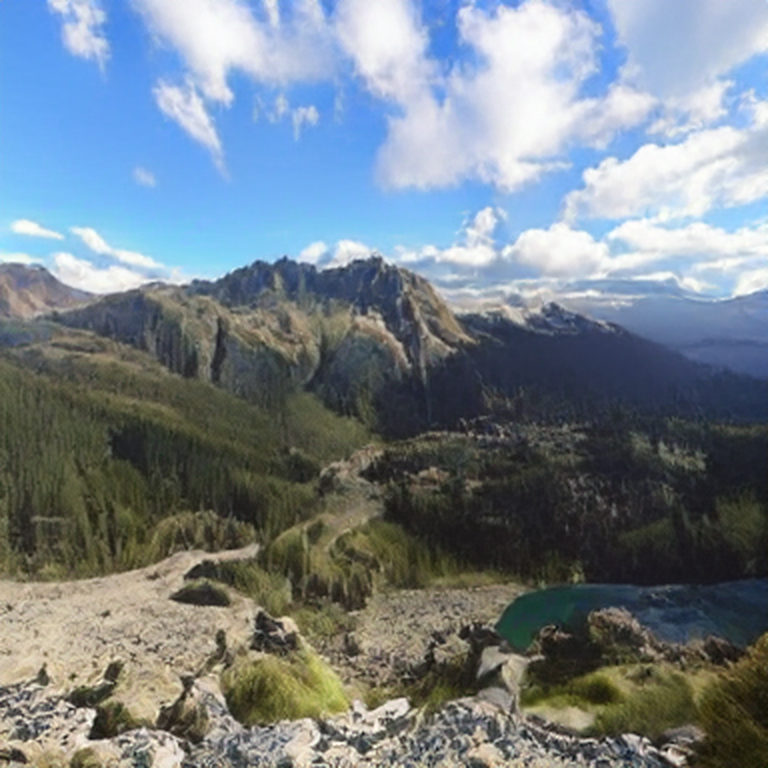

In [16]:
from IPython.display import display

images = generate_image("a scenic mountain view")

for i in range(len(images)):
    display(images[i])